CONTENTS:
- [Github API to understand user Contribution](#github-api-to-understand-user-contribution)
    - [These numbers come straight from the upstream repo via the REST API, so they only include commits and PRs where you’re the author or the committer on that repo. They **do not** pick up any work you did in a fork (or the individual commits squashed into a single merge), which is why they’ll always undercount what GitHub Insights shows for your overall contributions.](#these-numbers-come-straight-from-the-upstream-repo-via-the-rest-api,-so-they-only-include-commits-and-prs-where-you’re-the-author-or-the-committer-on-that-repo.-they-**do-not**-pick-up-any-work-you-did-in-a-fork-(or-the-individual-commits-squashed-into-a-single-merge),-which-is-why-they’ll-always-undercount-what-github-insights-shows-for-your-overall-contributions.)
  - [Set your Github PAT](#set-your-github-pat)
  - [Pre-feth all the data you need in cache](#pre-feth-all-the-data-you-need-in-cache)
    - [Query extraction takes time, so prefetch all data in cache for all the users, repos and time frames you need. once in cache there are several utility functions to help understand the user contribution. Following is the data we will fetch for users in multiple repos for the given period](#query-extraction-takes-time,-so-prefetch-all-data-in-cache-for-all-the-users,-repos-and-time-frames-you-need.-once-in-cache-there-are-several-utility-functions-to-help-understand-the-user-contribution.-following-is-the-data-we-will-fetch-for-users-in-multiple-repos-for-the-given-period)
  - [Combine the data for statistics and visualizations](#combine-the-data-for-statistics-and-visualizations)
  - [Compare users on a repo based on `commits`, `prs`, `additions` and `deletions`](#compare-users-on-a-repo-based-on-`commits`,-`prs`,-`additions`-and-`deletions`)
  - [See stats of a user on multiple repos based on `commits`, `prs`, `additions` and `deletions`](#see-stats-of-a-user-on-multiple-repos-based-on-`commits`,-`prs`,-`additions`-and-`deletions`)
  - [There are many more helper funcs to see and compare statistics. Look at github_utils for more info -> `tutorial_github_causify_style/github_utils.py`](#there-are-many-more-helper-funcs-to-see-and-compare-statistics.-look-at-github_utils-for-more-info-->-`tutorial_github_causify_style/github_utils.py`)

<a name='github-api-to-understand-user-contribution'></a>
# Github API to understand user Contribution

<a name='these-numbers-come-straight-from-the-upstream-repo-via-the-rest-api,-so-they-only-include-commits-and-prs-where-you’re-the-author-or-the-committer-on-that-repo.-they-**do-not**-pick-up-any-work-you-did-in-a-fork-(or-the-individual-commits-squashed-into-a-single-merge),-which-is-why-they’ll-always-undercount-what-github-insights-shows-for-your-overall-contributions.'></a>
### These numbers come straight from the upstream repo via the REST API, so they only include commits and PRs where you’re the author or the committer on that repo. They **do not** pick up any work you did in a fork (or the individual commits squashed into a single merge), which is why they’ll always undercount what GitHub Insights shows for your overall contributions.


In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim PyGithub)"
!jupyter labextension enable

In [11]:
import logging
import os
import datetime
import time
import importlib 

import github_utils
import helpers.hcache_simple as hcache
import helpers.hcache_simple as hcacsimp
from github import Github

# Enable logging.
logging.basicConfig(level=logging.INFO)
_LOG = logging.getLogger(__name__)

In [12]:
importlib.reload(github_utils)

<module 'github_utils' from '/app/tutorial_github_causify_style/github_utils.py'>

<a name='set-your-github-pat'></a>
## Set your Github PAT

In [29]:
# Set your GitHub access token here.
os.environ["GITHUB_ACCESS_TOKEN"] = "YOUR_GIT_PAT"

In [5]:
access_token = os.getenv("GITHUB_ACCESS_TOKEN")
if not access_token:
    _LOG.error("GITHUB_ACCESS_TOKEN not set. Exiting.")
    raise ValueError("Set GITHUB_ACCESS_TOKEN environment variable")

client = github_utils.GitHubAPI(access_token=access_token).get_client()

<a name='pre-feth-all-the-data-you-need-in-cache'></a>
## Pre-feth all the data you need in cache 

<a name='query-extraction-takes-time,-so-prefetch-all-data-in-cache-for-all-the-users,-repos-and-time-frames-you-need.-once-in-cache-there-are-several-utility-functions-to-help-understand-the-user-contribution.-following-is-the-data-we-will-fetch-for-users-in-multiple-repos-for-the-given-period'></a>
### Query extraction takes time, so prefetch all data in cache for all the users, repos and time frames you need. once in cache there are several utility functions to help understand the user contribution. Following is the data we will fetch for users in multiple repos for the given period 
- Prs opened in the repo
- Commits done
- LOC [additions and deletions]

In [19]:
github_utils.prefetch_periodic_user_repo_data(
    client,
    org="causify-ai",
    repos=["helpers","tutorials","cmamp"],
    users=["tkpratardan","Prahar08modi","Shaunak01"],
    period=(
        datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 5, 24, tzinfo=datetime.timezone.utc),
    ),
)


INFO:github_utils:Starting prefetch for repo helpers.
INFO:github_utils:Fetched 20 commits for causify-ai/helpers user=Shaunak01.
INFO:github_utils:Found 24 PRs for causify-ai/helpers user=Shaunak01.
INFO:github_utils:Fetched LOC stats for causify-ai/helpers user=Shaunak01 entries=20.
INFO:github_utils:Starting prefetch for repo tutorials.
INFO:github_utils:Fetched 1 commits for causify-ai/tutorials user=Shaunak01.
INFO:github_utils:Found 3 PRs for causify-ai/tutorials user=Shaunak01.
INFO:github_utils:Fetched LOC stats for causify-ai/tutorials user=Shaunak01 entries=1.
INFO:github_utils:Starting prefetch for repo cmamp.
INFO:github_utils:Fetched 23 commits for causify-ai/cmamp user=Shaunak01.
INFO:github_utils:Found 28 PRs for causify-ai/cmamp user=Shaunak01.
INFO:github_utils:Fetched LOC stats for causify-ai/cmamp user=Shaunak01 entries=23.
INFO:github_utils:Prefetched 9 user-repo combos in 62.79 seconds for period 2025-01-01 00:00:00+00:00 to 2025-05-24 00:00:00+00:00.


<a name='combine-the-data-for-statistics-and-visualizations'></a>
## Combine the data for statistics and visualizations

In [20]:
combined = github_utils.collect_all_metrics(
    client, org="causify-ai",
    repos=["helpers","tutorials","cmamp"],
    users=["Prahar08modi","tkpratardan","Shaunak01"],
    period=(datetime.datetime(2025,1,1, tzinfo=datetime.timezone.utc),
            datetime.datetime(2025,5,24, tzinfo=datetime.timezone.utc)),
)

INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily commit DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily PR DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily LOC DataFrame rows=144 (no data).
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily commit DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily PR DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily LOC DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily commit DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily PR DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily LOC DataFrame rows=144.
INFO:github_utils:Generated 144 days in period.
INFO:github_utils:

<a name='compare-users-on-a-repo-based-on-`commits`,-`prs`,-`additions`-and-`deletions`'></a>
## Compare users on a repo based on `commits`, `prs`, `additions` and `deletions`

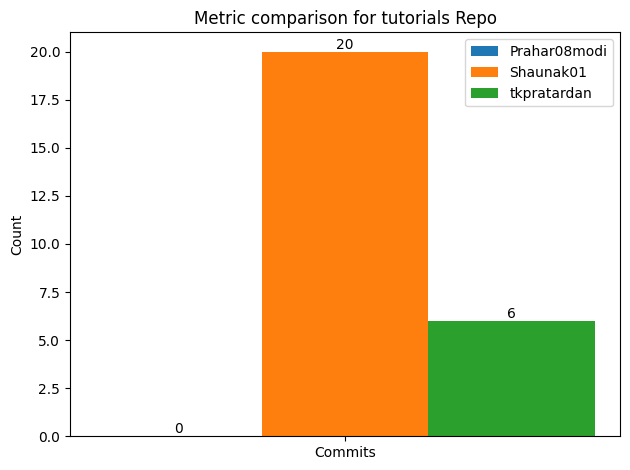

In [22]:
helpers_summary = github_utils.summarize_user_metrics_for_repo(
    combined,
    repo="helpers",
)
github_utils.plot_metrics_by_user(
    helpers_summary,
    repo="tutorials",
    metrics=['commits'],
)


<a name='see-stats-of-a-user-on-multiple-repos-based-on-`commits`,-`prs`,-`additions`-and-`deletions`'></a>
## See stats of a user on multiple repos based on `commits`, `prs`, `additions` and `deletions`

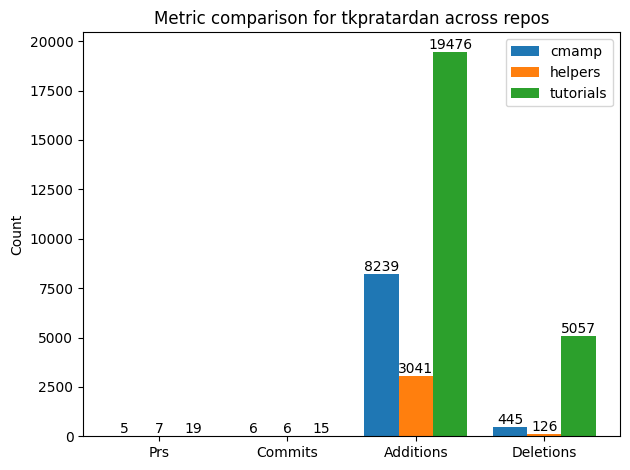

In [25]:
krishna_summary = github_utils.summarize_repo_metrics_for_user(
    combined,
    user="tkpratardan",
)

# then plot PRs and commits across their repos
github_utils.plot_metrics_by_repo(
    krishna_summary,
    user="tkpratardan",
    metrics=['prs', 'commits','additions','deletions'],
)

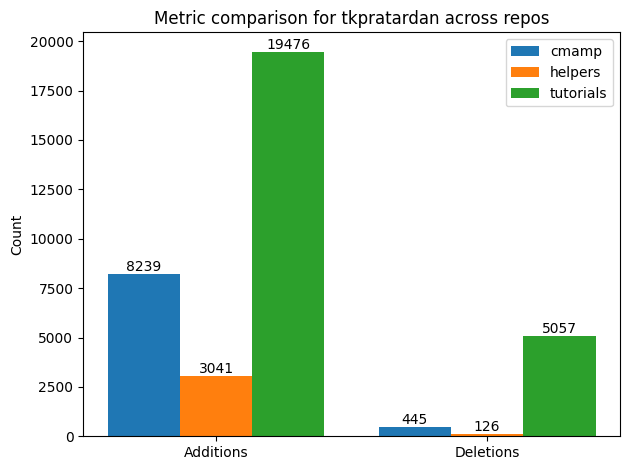

In [26]:
krishna_summary_2 = github_utils.summarize_repo_metrics_for_user(
    combined,
    user="tkpratardan",
)

github_utils.plot_metrics_by_repo(
    krishna_summary_2,
    user="tkpratardan",
    metrics=['additions', 'deletions'],
)


In [27]:
krishna_daily_commits = github_utils.build_daily_commit_df(
    client, org="causify-ai",
    repo="helpers",
    username="tkpratardan",
    period=(datetime.datetime(2025,1,1, tzinfo=datetime.timezone.utc),
            datetime.datetime(2025,5,24, tzinfo=datetime.timezone.utc)),
)

INFO:github_utils:Generated 144 days in period.
INFO:github_utils:Built daily commit DataFrame rows=144.


In [28]:
krishna_daily_commits[0:25]

,date,commits,repo,user
0,2025-01-01,0,helpers,tkpratardan
1,2025-01-02,0,helpers,tkpratardan
2,2025-01-03,0,helpers,tkpratardan
3,2025-01-04,0,helpers,tkpratardan
4,2025-01-05,0,helpers,tkpratardan
5,2025-01-06,0,helpers,tkpratardan
6,2025-01-07,0,helpers,tkpratardan
7,2025-01-08,0,helpers,tkpratardan
8,2025-01-09,0,helpers,tkpratardan
9,2025-01-10,0,helpers,tkpratardan


<a name='there-are-many-more-helper-funcs-to-see-and-compare-statistics.-look-at-github_utils-for-more-info-->-`tutorial_github_causify_style/github_utils.py`'></a>
## There are many more helper funcs to see and compare statistics. Look at github_utils for more info -> `tutorial_github_causify_style/github_utils.py`